In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import re
from sklearn.utils import shuffle
from sklearn import preprocessing
import pymc

%matplotlib inline  
plt.style.use('ggplot')

# Regression for Moore's Law

/home/george/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


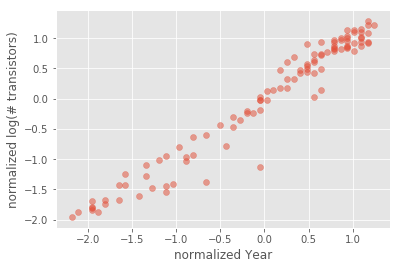

In [2]:
# Load and preprocess data
X = []
Y = []

non_decimal = re.compile(r'[^\d]+')

for line in open('moore.csv'):
    r = line.split('\t')
    x = int(non_decimal.sub('', r[2].split('[')[0]))
    y = int(non_decimal.sub('', r[1].split('[')[0]))
    X.append(x)
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
X, Y = shuffle(X, Y, random_state=0)
X.shape = (X.shape[0], 1)
X = preprocessing.scale(X)
Y = preprocessing.scale(np.log(Y))

# split data into training and test set
N, M = X.shape
idx = int(0.8*N)
X_train = X[:idx, :]
Y_train = Y[:idx]
N_train = idx
X_test = X[idx:, :]
Y_test = Y[idx:]
N_test = N - N_train

plt.scatter(X, Y, alpha=0.5)
plt.xlabel('normalized Year')
plt.ylabel('normalized log(# transistors)')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_36030b2f791b9c5af7b249ce0b9313d1 NOW.


Inference for Stan model: anon_model_36030b2f791b9c5af7b249ce0b9313d1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        -0.06  1.3e-3   0.07  -0.21  -0.11  -0.06  -0.01   0.09   3195    1.0
beta[0]           0.97  1.5e-3   0.09   0.79   0.91   0.97   1.02   1.13   3218    1.0
sigma             0.33  1.2e-3   0.06   0.24   0.29   0.32   0.36   0.46   2524    1.0
lambda            5.81    0.19   9.36   0.58   1.51   3.04    6.5  27.34   2339    1.0
Y_pred[0]        -0.84  5.8e-3   0.35   -1.5  -1.07  -0.84  -0.63  -0.11   3641    1.0
Y_pred[1]        -0.11  5.5e-3   0.34  -0.79  -0.33   -0.1    0.1   0.57   3804    1.0
Y_pred[2]         0.85  5.5e-3   0.35   0.17   0.63   0.85   1.07   1.53   4000    1.0
Y_pred[3]         0.12  5.3e-3   0.34  -0.54   -0.1   0.12   0.34   0.78   4000    1.0
Y_pred[4]        -0.11  5.6e

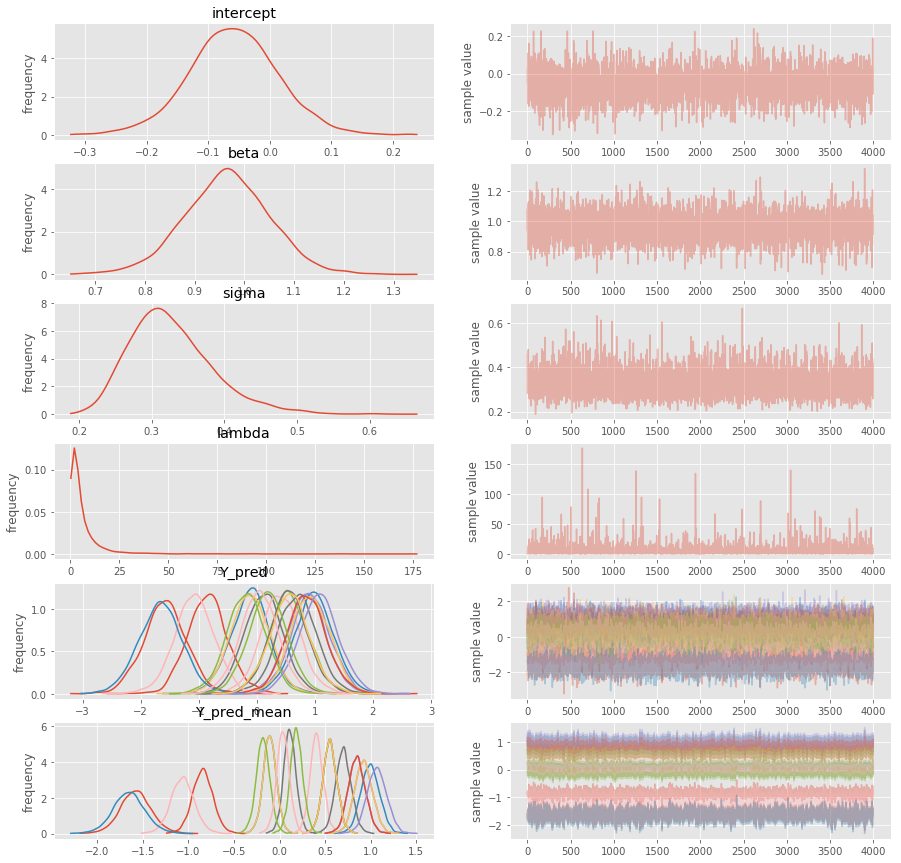

In [3]:
# Pystan model for Ridge Regression

ridge_code = """

data {
    int<lower=0> M; // number of predictors
    int<lower=0> N_train; // number of observations on training
    matrix[N_train, M] X_train; // predictors matrix for training
    vector[N_train] Y_train; // response vector for training
    int<lower=0> N_test; // number of observations on test
    matrix[N_test, M] X_test; // predictors matrix for test
}


parameters {
    real intercept;
    vector[M] beta;
    real<lower=0> sigma;
    real<lower=0> lambda;
}

model {
    vector[N_train] Y_mean;

    // Linear model
    Y_mean = X_train*beta + intercept;
    
    // Likelihood
    Y_train ~ normal(Y_mean, sigma);    
    
    // Priors
    intercept ~ normal(0, 10);
    beta ~ normal(0, lambda);
    sigma ~ cauchy(0, 10);
    lambda ~ cauchy(0, 10);
}

generated quantities {
    vector[N_test] Y_pred;
    vector[N_test] Y_pred_mean;
    
    Y_pred_mean = X_test*beta + intercept;
    for (i in 1:N_test)
        Y_pred[i] = normal_rng(Y_pred_mean[i], sigma); //the y values predicted by the model
}
"""

# dictionary containing data
data = {
    'X_train': X_test,
    'Y_train': Y_test,
    'N_train': N_test,
    'X_test': X_test,
    'N_test': N_test,
    'M': M
}

# fit model
fit = pystan.stan(model_code=ridge_code, data=data, iter=2000, chains=4)
print(fit)

fig = fit.plot()
fig.set_size_inches(15, 15)

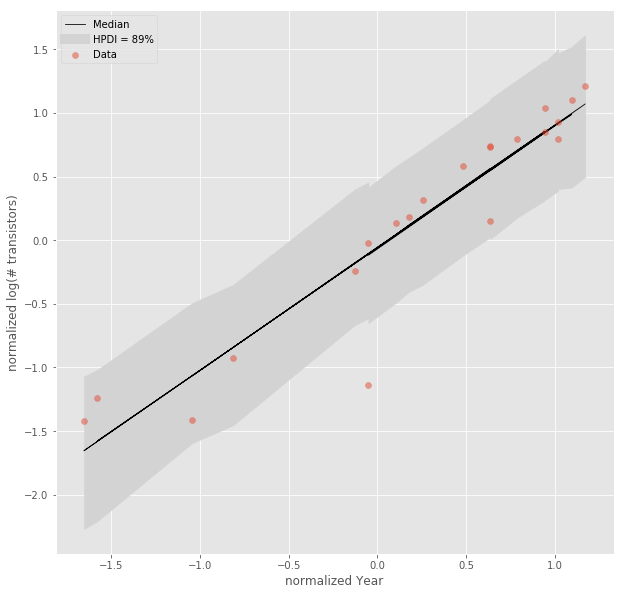

In [4]:
Y_pred = fit.extract('Y_pred')['Y_pred']
Y_hpdi = pymc.utils.hpd(Y_pred, 0.11)
Y_lower = Y_hpdi[0, :]
Y_upper = Y_hpdi[1, :]

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
ax.plot(X_test, np.median(Y_pred, axis=0), linewidth=0.8, color='k', label='Median', zorder=2)
ax.scatter(X_test, Y_test, alpha=0.5, label='Data', zorder=3)
sorted_x = X_test[:, 0].argsort()
Y_upper = Y_upper[sorted_x]
Y_lower = Y_lower[sorted_x]
X_test_sorted = X_test[sorted_x, :]
ax.fill_between(X_test_sorted[:, 0], Y_upper, Y_lower, color='lightgrey')
ax.plot([], [], color='lightgrey', label='HPDI = 89%', linewidth=10)
ax.legend(loc='upper left')
plt.xlabel('normalized Year')
plt.ylabel('normalized log(# transistors)')

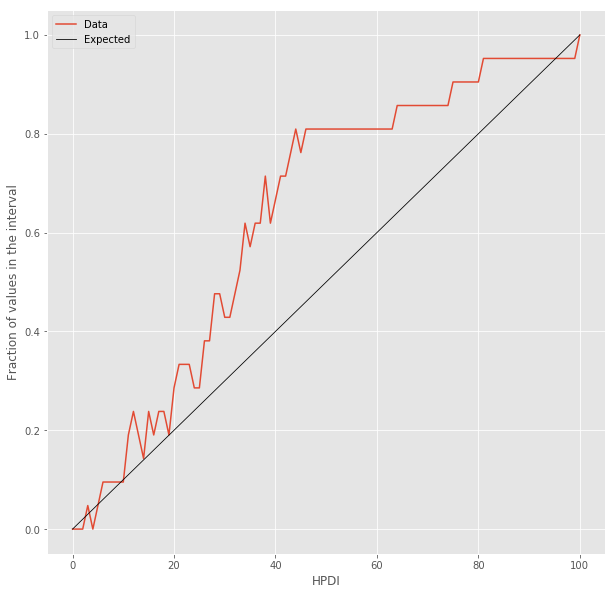

In [5]:
# Calibration curve

def calibration_curve(Y_pred, Y):
    calibration = np.zeros(101)
    for i in range(101):
        Y_hpdi = pymc.utils.hpd(Y_pred, max((100.0 - i) / 100.0, 1e-10))
        calibration[i] = ((Y >= Y_hpdi[0, :]) & (Y <= Y_hpdi[1, :])).mean()
    plt.figure(figsize=(10, 10))
    plt.plot(calibration, label='Data')
    line = np.linspace(0, 100, 100)
    plt.plot(line, line / 100.0, color='k', linewidth=0.8, label='Expected')
    plt.xlabel('HPDI')
    plt.ylabel('Fraction of values in the interval')
    plt.legend(loc='upper left')
    
calibration_curve(Y_pred, Y_test)